<a href="https://colab.research.google.com/github/vaibhavsundharam/Speech-Emotion-Analysis/blob/main/CNN_LSTM_MS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#General Initialization (Run)

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
import tqdm.notebook as tq
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# modify "customized_path_to_project", path of folder in drive, where you have stored your project
customized_path_to_project = "/content/drive/MyDrive/Deep Learning/DL Project"
sys.path.append(customized_path_to_project)

# Data Exploration (Run)

Importing the dataset<br>

1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
2. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
3. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
4. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
5. Repetition (01 = 1st repetition, 02 = 2nd repetition).
6. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
RAVDESS = os.path.join(customized_path_to_project, "Data", "RAVDESS")

# Looking at folders in this directory (should be 24) 
list_dir = os.listdir(RAVDESS)
list_dir.sort()
print(f"DIR Name: {list_dir}\n") # Actor 1 - Actor 24

emotion = []
gender = []
path = []
c = 1

for i in list_dir:
  filename = os.listdir(RAVDESS +'/' + i) #files in 'Actor 1' type folders (03-01-01-01-01-01-01.wav) 
  print(f"Counter :{c}\nFilename :{filename}\nNumber of .wav files: {len(filename)}\n\n")
  c += 1 
  for f in filename:    
    part = f.split('.')[0].split('-')  #getting labels i.e. 03 01 02 ... from "03-01-01-01-01-01-01.wav"      
    emotion.append(int(part[2]))
    temp = int(part[6])
    if temp % 2 == 0:
      temp = "female"
    else:
      temp = "male"
    gender.append(temp)
    path.append(RAVDESS + '/' + i + '/' + f)

DIR Name: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']

Counter :1
Filename :['03-01-01-01-01-01-01.wav', '03-01-01-01-01-02-01.wav', '03-01-01-01-02-01-01.wav', '03-01-01-01-02-02-01.wav', '03-01-02-01-01-01-01.wav', '03-01-02-01-02-01-01.wav', '03-01-02-01-01-02-01.wav', '03-01-02-01-02-02-01.wav', '03-01-02-02-01-01-01.wav', '03-01-02-02-01-02-01.wav', '03-01-02-02-02-01-01.wav', '03-01-02-02-02-02-01.wav', '03-01-03-01-01-01-01.wav', '03-01-03-01-01-02-01.wav', '03-01-03-01-02-01-01.wav', '03-01-03-01-02-02-01.wav', '03-01-03-02-01-01-01.wav', '03-01-03-02-01-02-01.wav', '03-01-03-02-02-01-01.wav', '03-01-03-02-02-02-01.wav', '03-01-04-01-01-01-01.wav', '03-01-04-01-01-02-01.wav', '03-01-04-01-02-01-01.wav', '03-01-04-01-02-02-01.wav', '03-01

##Putting necessary information into Data Frames and saving to csv files

In [ ]:
data_frame = RAVDESS_df = pd.DataFrame(path)
data_frame = pd.concat([pd.DataFrame(gender), RAVDESS_df], axis=1)
data_frame.columns = ['gender','path']
print(data_frame)

      gender                                               path
0       male  /content/drive/MyDrive/Deep Learning/DL Projec...
1       male  /content/drive/MyDrive/Deep Learning/DL Projec...
2       male  /content/drive/MyDrive/Deep Learning/DL Projec...
3       male  /content/drive/MyDrive/Deep Learning/DL Projec...
4       male  /content/drive/MyDrive/Deep Learning/DL Projec...
...      ...                                                ...
1435  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1436  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1437  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1438  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1439  female  /content/drive/MyDrive/Deep Learning/DL Projec...

[1440 rows x 2 columns]


##Seperating out *male* and *female* voices

In [ ]:
data_frame_male = data_frame.loc[data_frame['gender'] == 'male']
print(data_frame_male)
data_frame_male.to_csv('male.csv', index=False) 

     gender                                               path
0      male  /content/drive/MyDrive/Deep Learning/DL Projec...
1      male  /content/drive/MyDrive/Deep Learning/DL Projec...
2      male  /content/drive/MyDrive/Deep Learning/DL Projec...
3      male  /content/drive/MyDrive/Deep Learning/DL Projec...
4      male  /content/drive/MyDrive/Deep Learning/DL Projec...
...     ...                                                ...
1375   male  /content/drive/MyDrive/Deep Learning/DL Projec...
1376   male  /content/drive/MyDrive/Deep Learning/DL Projec...
1377   male  /content/drive/MyDrive/Deep Learning/DL Projec...
1378   male  /content/drive/MyDrive/Deep Learning/DL Projec...
1379   male  /content/drive/MyDrive/Deep Learning/DL Projec...

[720 rows x 2 columns]


In [ ]:
data_frame_female = data_frame.loc[data_frame['gender'] == 'female']
data_frame_female.to_csv('female.csv', index=False) 
print(data_frame_female)

      gender                                               path
60    female  /content/drive/MyDrive/Deep Learning/DL Projec...
61    female  /content/drive/MyDrive/Deep Learning/DL Projec...
62    female  /content/drive/MyDrive/Deep Learning/DL Projec...
63    female  /content/drive/MyDrive/Deep Learning/DL Projec...
64    female  /content/drive/MyDrive/Deep Learning/DL Projec...
...      ...                                                ...
1435  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1436  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1437  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1438  female  /content/drive/MyDrive/Deep Learning/DL Projec...
1439  female  /content/drive/MyDrive/Deep Learning/DL Projec...

[720 rows x 2 columns]


Playing audio file and plotting it to look at the output

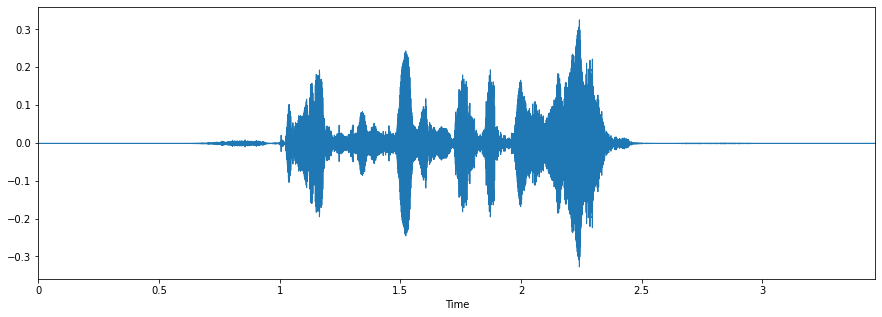

In [ ]:
# Picking a fearful track
fname = RAVDESS + '/' + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Playing the audio 
ipd.Audio(fname)

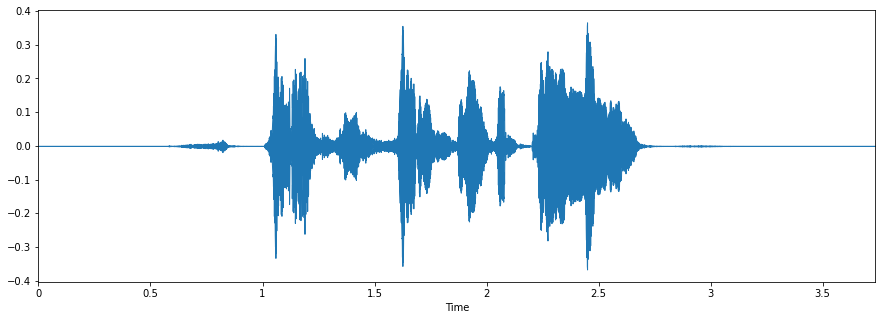

In [ ]:
# Picking a happy track
fname = RAVDESS + '/' + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Playing the audio 
ipd.Audio(fname)

# Feature Extraction (Run)

Using MFCC - Mel -frequency Cepstarl Coefficient

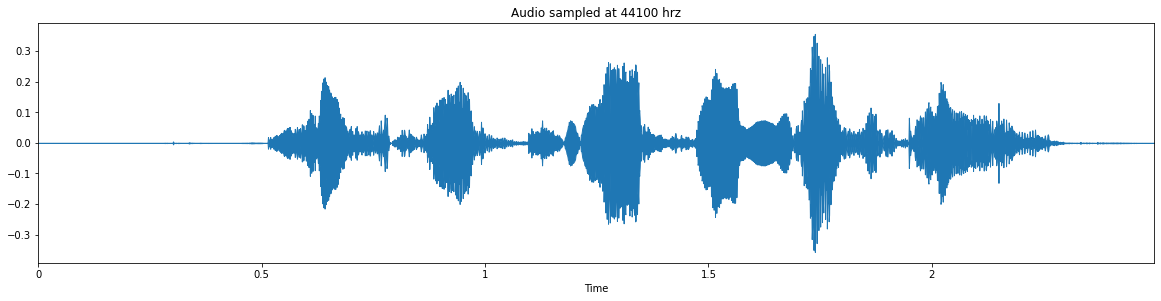

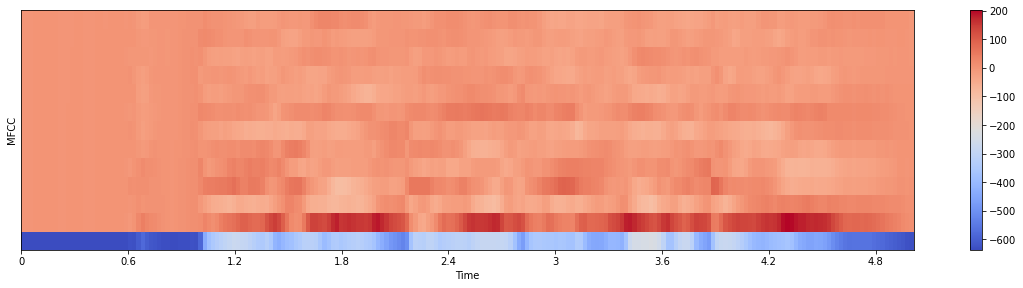

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
pathf = os.path.join(customized_path_to_project,"Data/RAVDESS/Actor_08/03-01-05-02-01-01-08.wav")
Xf, sample_ratef = librosa.load(pathf, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=Xf, sr=sample_ratef, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(Xf, sr=sample_ratef)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(pathf)

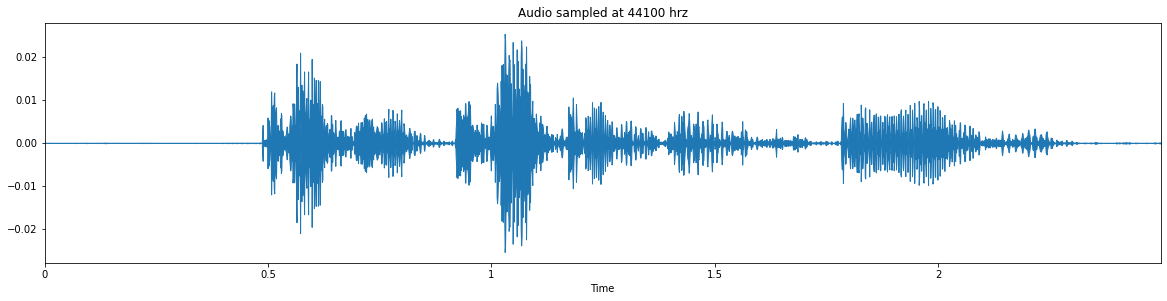

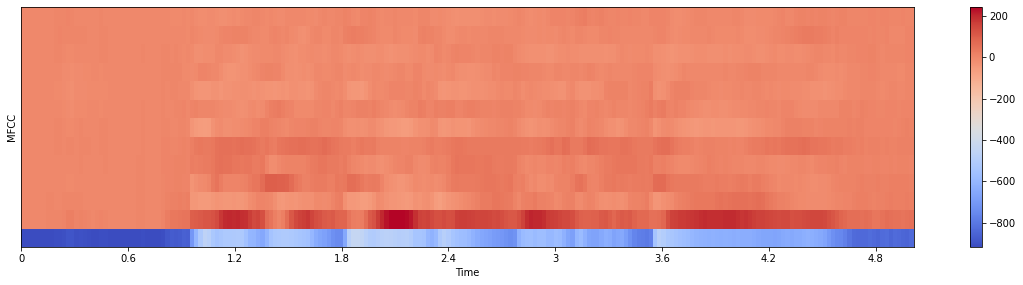

In [ ]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
pathm = os.path.join(customized_path_to_project,"Data/RAVDESS/Actor_09/03-01-05-01-01-01-09.wav")
Xm, sample_ratem = librosa.load(pathm, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=Xm, sr=sample_ratem, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(Xm, sr=sample_ratem)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(pathm)

216
216


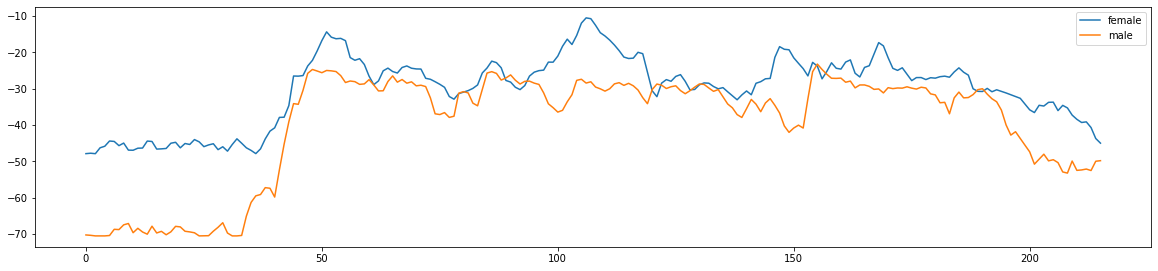

In [ ]:
#coeffiecients for female voice
female = np.mean(librosa.feature.mfcc(y=Xf, sr=sample_ratef, n_mfcc=13), axis=0)
print(len(female))

#coefficients for male voice
male = np.mean(librosa.feature.mfcc(y=Xm, sr=sample_ratem, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

Using Mel Spectrogram

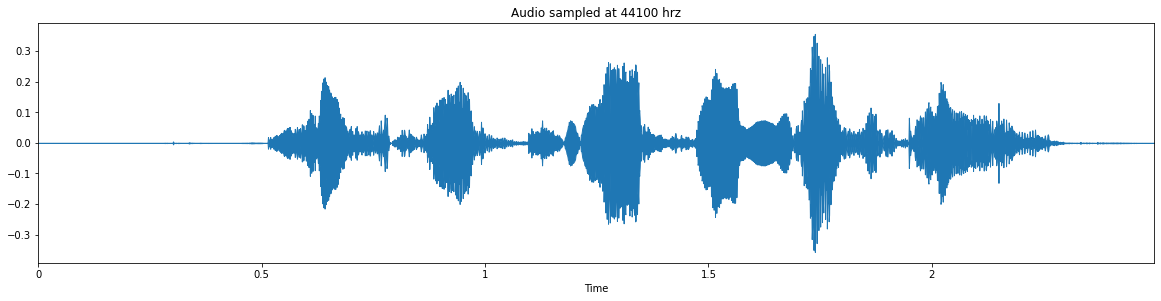

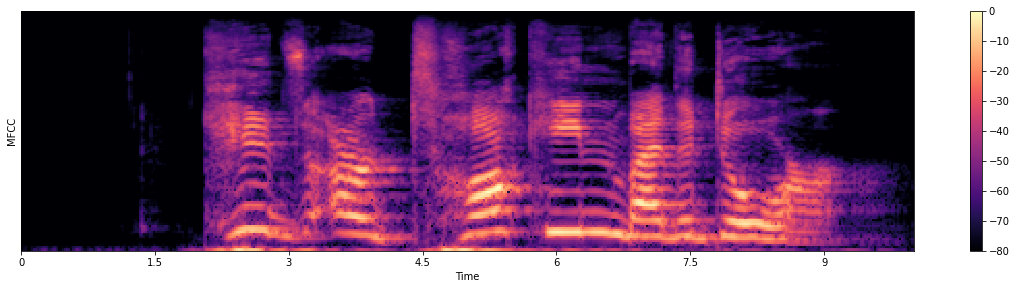

In [ ]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
pathf = os.path.join(customized_path_to_project,"Data/RAVDESS/Actor_08/03-01-05-02-01-01-08.wav")
Xf, sample_ratef = librosa.load(pathf, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mel_spec = librosa.feature.melspectrogram(y=Xf, sr=22050*2, n_fft=1024, hop_length=256, n_mels=128, fmax=22050*2/2)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(Xf, sr=sample_ratef)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mel_spec_db, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(pathf)

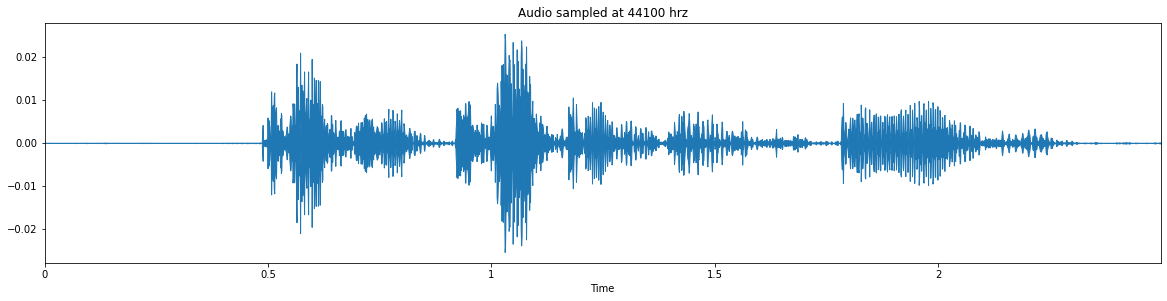

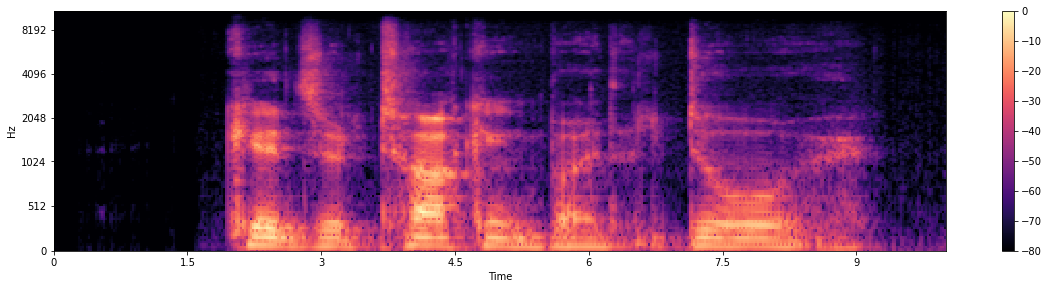

In [ ]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
pathm = os.path.join(customized_path_to_project,"Data/RAVDESS/Actor_09/03-01-05-01-01-01-09.wav")
Xm, sample_ratem = librosa.load(pathm, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)   
mel_spec = librosa.feature.melspectrogram(y=Xm, sr=22050*2, n_fft=1024, hop_length=256, n_mels=128, fmax=22050*2/2)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(Xm, sr=sample_ratem)
plt.title('Audio sampled at 44100 hrz')

# MEL
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time')
plt.colorbar()
ipd.Audio(pathm)

# Data Pre-processing (Run once)

In [ ]:
'''Global Initializations'''
SAMPLE_RATE = 48000
DURATION = 3.0
os.makedirs(os.path.join(customized_path_to_project, "pkl_files", "CNN_LSTM"), exist_ok=True)

In [ ]:
def MELSpectrogram(signal, sample_rate):
  mel_spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=1024, hop_length=256, n_mels=128, fmax=sample_rate/2)
  mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
  return mel_spec_db

In [ ]:
def AWGN(signal, num_bits=16, augmented_num=2, low=15, high=30): 
    len_signal = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, len_signal)) # shape: [augmented_num, len_signal]
    # Normalize signal and noise
    constant = 2.0**(num_bits-1)
    norm_signal = signal / constant
    norm_noise = noise / constant
    # Compute signal and noise power
    signal_power = np.sum(np.square(norm_signal)) / len_signal
    noise_power = np.sum(np.square(norm_noise), axis=1) / len_signal
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(low, high)
    # Compute cov:(covariance matrix) for each noise 
    cov = np.sqrt((signal_power / noise_power) * 10 ** (- target_snr / 10))    
    cov = np.ones((len_signal, augmented_num)) * cov 
    # Generate noisy signal
    return signal + cov.T * noise

#### Processing male voices

In [ ]:
# creating train, validation and test datarfame
from numpy.random import RandomState
df = pd.read_csv('/content/male.csv')
print(f"Total number of examples: {len(df)}")
train = df.sample(frac=0.8, random_state=200)
dev = df.loc[~df.index.isin(train.index)]
# splitting development set into val and test set
val = dev.iloc[:int(len(dev)/2), :]
test = dev.iloc[int(len(dev)/2):, :]
print(f"Total Number of examppe in training set: {len(train)}")
print(f"Total Number of examppe in validation set: {len(val)}")
print(f"Total Number of examppe in testing set: {len(test)}")

In [ ]:
df_features = pd.DataFrame(columns=["feature"])
df_path = pd.DataFrame(columns=['path'])
counter = 0

for p in tq.tqdm(train.path):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)
  # audio, _ = librosa.effects.trim(audio, top_db=30) # trimming silence 
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  audio_noise = AWGN(temp_audio)
  
  mel_spectrogram_o = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)  
  mel_spectrogram_n1 = MELSpectrogram(audio_noise[0,:], sample_rate=SAMPLE_RATE) 
  mel_spectrogram_n2 = MELSpectrogram(audio_noise[1,:], sample_rate=SAMPLE_RATE)  

  for j, signal in enumerate([mel_spectrogram_o, mel_spectrogram_n1, mel_spectrogram_n2]):       
    df_path.loc[j + counter] = p 
    df_features.loc[j + counter] = [signal]  
  counter += 3 

df = pd.concat([df_path, df_features], axis=1)
print(f"Shape of the dataframe:{df.shape}")
df.to_pickle("male_train.pkl")
!cp "/content/male_train.pkl" -r "/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/male_train.pkl"

In [ ]:
# validation
df_path =  pd.DataFrame(columns=["path"])
df_mel = pd.DataFrame(columns=["feature"])

for i, p in enumerate(tq.tqdm(val.path)):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)  
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  mel = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)
  df_path.loc[i] = p
  df_mel.loc[i]= [mel]

# df_mel = Normalize(df_mel)

df = pd.concat([df_path, df_mel], axis=1)
print(f"Shape of the dataframe:{df.shape}\n")
df.to_pickle("male_val.pkl")
!cp "/content/male_val.pkl" -r "/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/male_val.pkl"

# testing
df_path =  pd.DataFrame(columns=["path"])
df_mel = pd.DataFrame(columns=["feature"])

for i, p in enumerate(tq.tqdm(test.path)):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)  
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  mel = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)
  df_path.loc[i] = p
  df_mel.loc[i]= [mel]

# df_mel = Normalize(df_mel)

df = pd.concat([df_path, df_mel], axis=1)
print(f"Shape of the dataframe:{df.shape}\n")
df.to_pickle("male_test.pkl")
!cp "/content/male_test.pkl" -r "/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/male_test.pkl"

#### Processing female voices

In [ ]:
# creating train, validation and test datarfame
from numpy.random import RandomState
df = pd.read_csv('/content/female.csv')
print(f"Total number of examples: {len(df)}")
train = df.sample(frac=0.8, random_state=200)
dev = df.loc[~df.index.isin(train.index)]
# splitting development set into val and test set
val = dev.iloc[:int(len(dev)/2), :]
test = dev.iloc[int(len(dev)/2):, :]
print(f"Total Number of examppe in training set: {len(train)}")
print(f"Total Number of examppe in validation set: {len(val)}")
print(f"Total Number of examppe in testing set: {len(test)}")

In [ ]:
df_features = pd.DataFrame(columns=["feature"])
df_path = pd.DataFrame(columns=['path'])
counter = 0

for p in tq.tqdm(train.path):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)
  audio, _ = librosa.effects.trim(audio, top_db=30) # trimming silence 
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  audio_noise = AWGN(temp_audio)
  
  mel_spectrogram_o = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)  
  mel_spectrogram_n1 = MELSpectrogram(audio_noise[0,:], sample_rate=SAMPLE_RATE)
  mel_spectrogram_n2 = MELSpectrogram(audio_noise[1,:], sample_rate=SAMPLE_RATE)  

  for j, signal in enumerate([mel_spectrogram_o, mel_spectrogram_n1, mel_spectrogram_n2]):       
    df_path.loc[j + counter] = p 
    df_features.loc[j + counter] = [signal]  
  counter += 3 

df = pd.concat([df_path, df_features], axis=1)
print(f"Shape of the dataframe:{df.shape}")
df.to_pickle("female_train.pkl")
!cp "/content/female_train.pkl" -r "/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/female_train.pkl"

In [ ]:
# validation
df_path =  pd.DataFrame(columns=["path"])
df_mel = pd.DataFrame(columns=["feature"])

for i, p in enumerate(tq.tqdm(val.path)):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)  
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  mel = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)
  df_path.loc[i] = p
  df_mel.loc[i]= [mel]

# df_mel = Normalize(df_mel)

df = pd.concat([df_path, df_mel], axis=1)
print(f"Shape of the dataframe:{df.shape}\n")
df.to_pickle("female_val.pkl")
!cp "/content/female_val.pkl" -r "/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/female_val.pkl"

# testing
df_path =  pd.DataFrame(columns=["path"])
df_mel = pd.DataFrame(columns=["feature"])

for i, p in enumerate(tq.tqdm(test.path)):
  audio, _ = librosa.load(p, duration=DURATION, offset=0.5, sr=SAMPLE_RATE)  
  temp_audio = np.zeros((int(SAMPLE_RATE*DURATION,)))
  temp_audio[:len(audio)] = audio
  mel = MELSpectrogram(temp_audio, sample_rate=SAMPLE_RATE)
  df_path.loc[i] = p
  df_mel.loc[i]= [mel]

# df_mel = Normalize(df_mel)

df = pd.concat([df_path, df_mel], axis=1)
print(f"Shape of the dataframe:{df.shape}\n")
df.to_pickle("female_test.pkl")
!cp "/content/female_test.pkl" -r "/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/female_test.pkl"

#Data Loader (Run)

In [ ]:
# custom class to explore dataset
class Voice_dataset(Dataset):
  def __init__(self, pkl_location):    
    self.df = pd.read_pickle(pkl_location)  

  def normalize(self, data):
    return minmax_scale(data, feature_range=(0, 1))  

  def __len__(self):  # returns the length of the data set
     return len(self.df)

  def __getitem__(self, idx):  
    voice = dict()
    voice_labels = self.df.iloc[idx, 0].split("/")[-1].split(".")[0].split("-")       

    voice["emotion"] = int(voice_labels[2]) - 1    
    
    voice["features"] = self.df.iloc[idx, 1]       
    return voice

#  Model (Run)

In [ ]:
class CNN_LSTM(nn.Module):
  def __init__(self, num_emotions):
    super().__init__()
    # conv block
    self.conv2Dblock = nn.Sequential(
              # 1. conv block
              nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Dropout(p=0.3),
              # 2. conv block
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=4, stride=4),
              nn.Dropout(p=0.3),
              # 3. conv block
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=4, stride=4),
              nn.Dropout(p=0.3),
              # 4. conv block
              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=4, stride=4),
              nn.Dropout(p=0.3)
                                  )
    # LSTM block
    self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
    hidden_size = 128
    self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
    self.dropout_lstm = nn.Dropout(0.1)
    self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
    
    # Linear softmax layer
    self.out_linear = nn.Linear(2*hidden_size+256,num_emotions)
    self.dropout_linear = nn.Dropout(p=0)
        
  def forward(self,x):
    # conv embedding
    conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
    conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension

    # lstm embedding
    x_reduced = self.lstm_maxpool(x)
    x_reduced = torch.squeeze(x_reduced,1)
    x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
    lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
    lstm_embedding = self.dropout_lstm(lstm_embedding)
    batch_size,T,_ = lstm_embedding.shape 
    attention_weights = [None]*T

    for t in range(T):
      embedding = lstm_embedding[:,t,:]
      attention_weights[t] = self.attention_linear(embedding)
    attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
    attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
    attention = torch.squeeze(attention, 1)

    # concatenate
    complete_embedding = torch.cat([conv_embedding, attention], dim=1)         
    output_logits = self.out_linear(complete_embedding)
    output_logits = self.dropout_linear(output_logits)        
    return output_logits

# Helper functions

In [ ]:
'''Initializations'''
## Output directory to save weights
output_dir = customized_path_to_project + '/checkpoints/'
os.makedirs(output_dir, exist_ok=True)

train_set = Voice_dataset(pkl_location="/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/male_train.pkl")
val_set = Voice_dataset(pkl_location="/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/male_val.pkl")
test_set = Voice_dataset(pkl_location="/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/male_test.pkl")
print(f"Number of training examples: {len(train_set)}, Number of validation examples: {len(val_set)}, Number of testing examples: {len(test_set)} ")

Number of training examples: 1728, Number of validation examples: 72, Number of testing examples: 72 


In [ ]:
# helper function for computing accuracy
def get_acc(pred, y):
    pred = pred.float()    
    y = y.float()    
    prediction=((y==pred).sum().float()/y.shape[0])*100
    return torch.round(prediction)

# helper function for computing model accuracy
def get_model_acc(model, loader, test=False, path=None):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  emotions = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  total_step = len(loader)  
  criterion = nn.CrossEntropyLoss().to(device)
  loss = 0

  if test is True:
    print("Loading best weights for testing")
    model.load_state_dict(torch.load(path))

  model.eval()
  with torch.no_grad():
    ys_emotions = list()    
    y_preds_emotions = list()     

    for data in loader:
      features = data["features"].unsqueeze(1).float().to(device)
      emotions = data["emotion"].to(device)      
      ys_emotions.append(emotions)     

      # predictions
      predictions = model(features)          
      loss += criterion(predictions, emotions)       
      y_preds_emotions.append(torch.argmax(predictions, dim=1))      

    Ys_Emotions = torch.cat(ys_emotions, dim=0)    
    Y_Preds_Emotions = torch.cat(y_preds_emotions, dim=0)       
  return get_acc(Y_Preds_Emotions, Ys_Emotions), loss/total_step

In [ ]:
def train(train_set, val_set, save_path, num_epochs=100, batch_size=64, num_workers=8, lr=1e-4, log_step = 1, continue_training=False, path=None):   

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  writer = SummaryWriter(log_dir=output_dir+"runs/CNN_LSTM")  
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)  
  val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False, num_workers=num_workers)
  print(f"Total number of training example: {len(train_set)}\n")
  print(f"Total number of validation example: {len(val_set)}\n")

  #initialization#
  best_acc = None
  model = CNN_LSTM(num_emotions=8).to(device)
  optimizer =  optim.Adam(model.parameters(), lr = lr, betas=(0.5, 0.999), weight_decay=1e-4)
  total_step = len(train_loader)   
  criterion = nn.CrossEntropyLoss().to(device)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

  if continue_training == True:
    path = str(input("Enter model path: "))
    print("---Loading weights---")
    model.load_state_dict(torch.load(os.path.join(path)))

  print("---Training Model---") 

  for epoch in range(num_epochs):
    print(f"--- Epoch {epoch + 1} ---") 
    model.train()
    loss_epoch = 0
    accuracy = 0
    for itr, data in enumerate(train_loader):
      optimizer.zero_grad()

      features = data["features"].unsqueeze(1).float().to(device)      
      emotions = data["emotion"].to(device)      
      
      # predictions
      predictions = model(features)            

      # loss
      loss = criterion(predictions, emotions) 
      loss.backward()
      optimizer.step()
      loss_epoch += loss.item()

      # log performance
      if itr % log_step == 0:
        print(f"Printing running logs for epoch: {epoch+1} Step: {itr}/{total_step} ---> Loss: {loss}")        
    print("----------------------------------------------------")
    print(f"Loss for epoch {epoch +1} : {loss_epoch/total_step}")    

    print(f"Performing validation for epoch: {epoch + 1}")    
    train_sentiment_acc, t_loss = get_model_acc(model, train_loader)
    writer.add_scalar("Model/tarining_loss", t_loss, epoch)
    
    val_sentiment_acc, v_loss = get_model_acc(model, val_loader)
    writer.add_scalar("Model/val_sentiment_acc", val_sentiment_acc, epoch)
    writer.add_scalar("Model/val_loss", v_loss, epoch)

    print(f"Training loss: {t_loss} Training Accuracy for Voice Sentiment: {train_sentiment_acc} % ")
    print(f"Validation loss: {v_loss} Validation Accuracy for Voice Sentiment: {val_sentiment_acc} %")    
    
    
    scheduler.step(v_loss)
    if best_acc == None:
      best_acc = val_sentiment_acc
    elif val_sentiment_acc > best_acc:
      best_acc = val_sentiment_acc
      print(f"Updating Best accuracy to: {best_acc} %")
      torch.save(model.state_dict(), os.path.join(save_path, f"best_model_epoch_{epoch+1}.pth"))
    print("-----------------------------------------------------\n")
  return model

#Training (Male)

In [ ]:
save_path = os.path.join(output_dir, "weights", "CNN_LSTM", "Male")
os.makedirs(save_path, exist_ok=True)
model = train(train_set=train_set, val_set=val_set, save_path=save_path, num_epochs=150, log_step = 5, batch_size=124, num_workers=8, lr=0.001, continue_training=False)

Total number of training example: 1728

Total number of validation example: 72

---Training Model---
--- Epoch 1 ---
Printing running logs for epoch: 1 Step: 0/14 ---> Loss: 2.2913646697998047
Printing running logs for epoch: 1 Step: 5/14 ---> Loss: 2.1583142280578613
Printing running logs for epoch: 1 Step: 10/14 ---> Loss: 2.0923802852630615
----------------------------------------------------
Loss for epoch 1 : 2.16579840864454
Performing validation for epoch: 1
Training loss: 2.082508087158203 Training Accuracy for Voice Sentiment: 21.0 % 
Validation loss: 2.041501045227051 Validation Accuracy for Voice Sentiment: 28.0 %
-----------------------------------------------------

--- Epoch 2 ---
Printing running logs for epoch: 2 Step: 0/14 ---> Loss: 2.016242027282715
Printing running logs for epoch: 2 Step: 5/14 ---> Loss: 2.0756001472473145
Printing running logs for epoch: 2 Step: 10/14 ---> Loss: 1.9627162218093872
----------------------------------------------------
Loss for epoch 

#Testing Male Voices

In [ ]:
best_path = os.path.join(output_dir, "weights", "CNN_LSTM", "Male", "best_model_epoch_61.pth")
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM(num_emotions=8).to(device)
test_sentiment_acc, test_loss = get_model_acc(model, test_loader , test=True, path=best_path)
print(f"Testing loss: {test_loss} Testing Accuracy for Voice Sentiment: {test_sentiment_acc} %")

Loading best weights for testing
Testing loss: 1.082311987876892 Testing Accuracy for Voice Sentiment: 60.0 %


# Training (Female)

In [ ]:
'''Initializations'''
## Output directory to save weights
output_dir = customized_path_to_project + '/checkpoints/'
os.makedirs(output_dir, exist_ok=True)

train_set = Voice_dataset(pkl_location="/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/female_train.pkl")
val_set = Voice_dataset(pkl_location="/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/female_val.pkl")
test_set = Voice_dataset(pkl_location="/content/drive/MyDrive/Deep Learning/DL Project/pkl_files/CNN_LSTM/female_test.pkl")
print(f"Number of training examples: {len(train_set)}, Number of validation examples: {len(val_set)}, Number of testing examples: {len(test_set)} ")

Number of training examples: 1728, Number of validation examples: 72, Number of testing examples: 72 


In [ ]:
save_path = os.path.join(output_dir, "weights", "CNN_LSTM", "Female")
os.makedirs(save_path, exist_ok=True)
model = train(train_set=train_set, val_set=val_set, save_path=save_path, num_epochs=150, log_step = 5, batch_size=124, num_workers=8, lr=0.001, continue_training=False)

Total number of training example: 1728

Total number of validation example: 72

---Training Model---
--- Epoch 1 ---
Printing running logs for epoch: 1 Step: 0/14 ---> Loss: 2.355314016342163
Printing running logs for epoch: 1 Step: 5/14 ---> Loss: 2.0715925693511963
Printing running logs for epoch: 1 Step: 10/14 ---> Loss: 2.0678446292877197
----------------------------------------------------
Loss for epoch 1 : 2.125925762312753
Performing validation for epoch: 1
Training loss: 2.014627695083618 Training Accuracy for Voice Sentiment: 14.0 % 
Validation loss: 2.1499218940734863 Validation Accuracy for Voice Sentiment: 8.0 %
-----------------------------------------------------

--- Epoch 2 ---
Printing running logs for epoch: 2 Step: 0/14 ---> Loss: 2.0422825813293457
Printing running logs for epoch: 2 Step: 5/14 ---> Loss: 1.9358009099960327
Printing running logs for epoch: 2 Step: 10/14 ---> Loss: 1.9096096754074097
----------------------------------------------------
Loss for epoch

# Testing Female Voices

In [ ]:
best_path = os.path.join(output_dir, "weights", "CNN_LSTM", "Female", "best_model_epoch_38.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM(num_emotions=8).to(device)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=8)
test_sentiment_acc, test_loss = get_model_acc(model, test_loader , test=True, path=best_path)
print(f"Testing loss: {test_loss} Testing Accuracy for Voice Sentiment: {test_sentiment_acc} %")

Loading best weights for testing
Testing loss: 1.3617160320281982 Testing Accuracy for Voice Sentiment: 44.0 %
